In [19]:
'''
Considerations
-train neural net within ages of 2-6 Gyrs: we know M67 has an age of about 4Gyrs, so there is no point to training it outside this range
-We want to have a working neural net that works to a precision of 0.005 dex (0.5% precision), though we should make a determination of how accurate we want it to be. 
-Most logical loss function is MAE (mean absolute error), although the Median Absolute Error is smaller. We probably want to train using the Mean Absolute Error and then evaluate using the Median Absolute Error.
-To determine an adequate guess than the number of epochs to train for we can take a small portion of the grid (e.g. say only where the metallicity is solar and take a few masses) train the neural net till it reaches the desired precision, suggested architecture (3,8,8,2) = (inputs,nodes, hidden layers, outputs).
-Sensible number of epochs = 50,000
-We want to try an architecture which is the smallest we can get away with such that its faster (start with small architecture and work up).
'''
#import seaborn as sns
#import pandas as pd
#import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
data = np.genfromtxt('grid_0_0.csv',delimiter=",",skip_header=1)

'''
[0]=row
[1]=model_number
[2]=star_mass
[3]=star_age
[4]=star_feh
[5]=star_MLT
[6]=star_fov
[7]=effective_T
[8]=luminosity
[9]=radius
[10]=log_g
[11]=surface_h1
[12]=surface_he4
[13]=center_h1
[14]=center_he4
[15]=log_center_T
[16]=log_center_Rho
[17]=he_core_mass
[18]=delta_nu
[19]=delta_Pg
[20]=nu_max
[21]=nu_0_10
[22]=nu_0_11
[23]=nu_0_12
[24]=nu_0_13
[25]=nu_0_14
[26]=nu_0_15
'''

'\n[0]=row\n[1]=model_number\n[2]=star_mass\n[3]=star_age\n[4]=star_feh\n[5]=star_MLT\n[6]=star_fov\n[7]=effective_T\n[8]=luminosity\n[9]=radius\n[10]=log_g\n[11]=surface_h1\n[12]=surface_he4\n[13]=center_h1\n[14]=center_he4\n[15]=log_center_T\n[16]=log_center_Rho\n[17]=he_core_mass\n[18]=delta_nu\n[19]=delta_Pg\n[20]=nu_max\n[21]=nu_0_10\n[22]=nu_0_11\n[23]=nu_0_12\n[24]=nu_0_13\n[25]=nu_0_14\n[26]=nu_0_15\n'

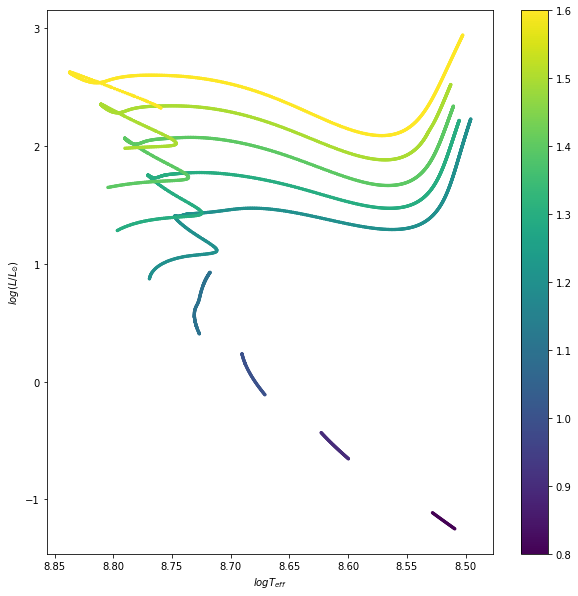

'\nfor i in range(len(tracks)):\n    track = data[:,3][tracks[i][0]:tracks[i][1]+1]\n    print([track[0],track[-1]])\n    #print([data[:,3][tracks[i][0]],data[:,3][tracks[i][1]]])\n    #print([data[:,3][tracks[i][0]+1],data[:,3][tracks[i][1]+1]])\n'

In [79]:
def find_tracks(data):
    track_starts = np.where(data[:,0] == 0)[0]
    track_ends = np.append(track_starts[1:]-1,len(data[:,0])-1)
    tracks = list(zip(track_starts,track_ends))
    return tracks

def limit_age_range(lower_bounds,upper_bounds,data):
    tracks = find_tracks(data=data)
    limited_tracks = []
    for i in range(len(tracks)):
        track = data[:,3][tracks[i][0]:tracks[i][1]+1]
        lb = (np.abs(track - lower_bounds)).argmin() + tracks[i][0]
        ub = (np.abs(track - upper_bounds)).argmin()+ tracks[i][0]
        if data[:,3][ub] > lower_bounds: #makes stars that are really young aren't included if their maximum age is less than the lower bounds
            limited_tracks.append([lb,ub])
    limited_trackes_indeces = []
    for i in range(len(limited_tracks)):
        limited_trackes_indeces+=list(range(limited_tracks[i][0],limited_tracks[i][1]+1))
        
    return limited_tracks,limited_trackes_indeces

def HRplot(tracks,L,T,M,single_plot=True):
    luminosities = L[tracks[0][0]:tracks[0][1]+1]
    temperatures = T[tracks[0][0]:tracks[0][1]+1]
    masses = M[tracks[0][0]:tracks[0][1]+1]
    for i in range(1,len(tracks)):
        luminosities = np.append(luminosities,L[tracks[i][0]:tracks[i][1]+1])
        temperatures = np.append(temperatures,T[tracks[i][0]:tracks[i][1]+1])
        masses = np.append(masses,M[tracks[i][0]:tracks[i][1]+1])
    if single_plot == True:
        fig, ax=plt.subplots(1,1,figsize=[10,10])
        s1=ax.scatter(np.log(temperatures),np.log(luminosities),s=5,c=masses,cmap='viridis')
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.set_ylabel(r'$log(L/L_{\odot})$')
        ax.set_xlabel(r'$log T_{eff}$')
        fig.colorbar(s1)
        plt.show()
    else:
        return luminosities,temperatures,masses
        
def plotHist(training,model,input_data):
    #print(training.__dict__)
    #'''
    fig, ax = plt.subplots(nrows = 3, ncols=1, figsize=(10,20))
    ax = ax.flatten()
    
    epoch_list = training.epoch
    MAE = training.history['mae']
    valMAE=training.history['val_mae']
    MSE = training.history['mae']
    valMSE = training.history['val_mse']
    ax[0].plot(epoch_list,MAE,'b',label='mae')
    ax[0].plot(epoch_list,valMAE,'r',label='valmae')
    ax[0].plot(epoch_list,MSE,'b:',label='mse')
    ax[0].plot(epoch_list,valMSE,'r:',label='valmse')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('metric')
    ax[0].legend()
    
    tracks,track_indeces = limit_age_range(lower_bounds=2,upper_bounds=6,data=data)
    luminosities,temperatures,masses = HRplot(tracks,L=data[:,8],T=data[:,7],M=data[:,2],single_plot=False)
    
    ax[1].scatter(np.log(temperatures),np.log(luminosities),s=5,c=masses,cmap='viridis')
    ax[1].invert_xaxis()
    ax[1].set_ylabel(r'$log(L/L_{\odot})$')
    ax[1].set_xlabel(r'$log T_{eff}$')
    
    prediction = model.predict(input_data,verbose=2).T
    s2 = ax[2].scatter(np.log(prediction[0]),np.log(prediction[1]),s=5,c=masses,cmap='viridis')
    ax[2].invert_xaxis()
    ax[2].set_ylabel(r'$log(L/L_{\odot})$')
    ax[2].set_xlabel(r'$log T_{eff}$')
    fig.colorbar(s2)
    
    
    plt.show()
    #'''

def get_headers(file):
    import csv
    with open('grid_0_0.csv','r') as in_file:
        reader = csv.reader(in_file)
        headers = []
        for line in reader:
            headers.append(line)
            break
    
    headers_dict = {}
    for i in range(len(headers[0])):
        headers_dict[headers[0][i]] = i
    return headers_dict
    
    
#full_tracks = find_tracks(data=data)
tracks,track_indeces = limit_age_range(lower_bounds=2,upper_bounds=6,data=data)
HRplot(tracks=tracks,L=data[:,8],T=data[:,7],M=data[:,2])

'''
for i in range(len(tracks)):
    track = data[:,3][tracks[i][0]:tracks[i][1]+1]
    print([track[0],track[-1]])
    #print([data[:,3][tracks[i][0]],data[:,3][tracks[i][1]]])
    #print([data[:,3][tracks[i][0]+1],data[:,3][tracks[i][1]+1]])
'''
#vals = np.vstack((data[[track_indeces],2],data[[track_indeces],3])).T
#print(len(vals))

In [70]:
def NN_setup(input_data,output_data,nodes,Hidden_layers,regularization,learning_rate,beta_1,beta_2,epsilon,new=True): #inputs = list where each element is all the desired data for a varaible i.e. data[:,2][track_indeces]
    #new = True #train new neural net
    if new == True:
        inputs=keras.Input(shape=(len(input_data),))
        xx=keras.layers.Dense(nodes,activation='relu')(inputs)
        for i in range(Hidden_layers-1):
            if regularization != False:
                xx = layers.Dense(nodes, activation='relu',kernel_regularizer=keras.regularizers.l1(regularization))(xx)
            else:
                xx = layers.Dense(nodes, activation='relu')(xx)
        outputs=keras.layers.Dense(len(output_data),activation='linear')(xx)

        model = keras.Model(inputs=inputs, outputs=outputs)
    else:
        model = keras.models.load_model('NN_attempt2.h5')
    
    opt = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model.compile(optimizer=opt,
                  loss='MAE',
                  metrics=['mae', 'mse'])
    return model


def train_NN(input_data,output_data,epochs,validation_fraction,nodes,Hidden_layers,regularization,learning_rate,beta_1,beta_2,epsilon,new=True):
    model = NN_setup(new=new,input_data=input_data,output_data=output_data,nodes=nodes,Hidden_layers=Hidden_layers,regularization=regularization,learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2,epsilon=epsilon)
    #print(np.shape(input_data))
    #print(np.shape(output_data))
    training = model.fit(input_data.T, output_data.T,
        epochs=epochs,
        batch_size=len(input_data[0]),
        validation_split=validation_fraction,
        verbose=0)
        #callbacks=[epoch_progression().on_epoch_end(epoch,logs,progress=progress)])
    model.save('NN_small_grid.h5')
    print('Training Finished at: '+str(datetime.now()))
    plotHist(training,model,input_data=input_data.T)
    return training



def epochs_progress(epochs=epochs,perc_step = 'ten'): #perc_step either takes 'ten' or 'one'
    #eps = np.array(list(range(epochs)))
    eps_perc = np.array(list(range(epochs)))/epochs

    if perc_step == 'one':
        percs = np.linspace(0,1,101)
    elif perc_step == 'ten':
        percs = np.linspace(0,1,11)
    else:
        perc_step_error = '"perc_step" takes the valid parameters "one" or "ten" not: "{}"'.format(perc_step)
        raise Exception(perc_step_error)
    perc_list = []
    for i in percs:
        perc_list.append(eps_perc[(np.abs(eps_perc - i)).argmin()])
    return perc_list

class epoch_progression(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch/epochs in progress:
            if len(progress) == 11:
                    #print("{}{}, {}".format(round(epoch/epochs,1)*100,'%',datetime.now().strftime("%Y%m%d-%H%M%S")))
                    print("{}{}, {}".format(round(epoch/epochs,1)*100,'%',datetime.now().strftime("%H:%M:%S")))
            else:
                    #print("{}{}, {}".format(round(epoch/epochs,2)*100,'%',datetime.now().strftime("%Y%m%d-%H%M%S")))
                    print("{}{}, {}".format(round(epoch/epochs,2)*100,'%',datetime.now().strftime("%H:%M:%S"))) 


0.0%, 17:01:39
10.0%, 17:07:14
20.0%, 17:12:52
30.0%, 17:18:41
40.0%, 17:24:35
50.0%, 17:30:13
60.0%, 17:36:05
70.0%, 17:41:44
80.0%, 17:47:22
90.0%, 17:53:00
100.0%, 17:58:04
Training Finished at: 2019-11-15 17:58:38.457440
5047/1 - 0s


C:\Users\Harry\Documents\Home\Anaconda\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in log
C:\Users\Harry\Documents\Home\Anaconda\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


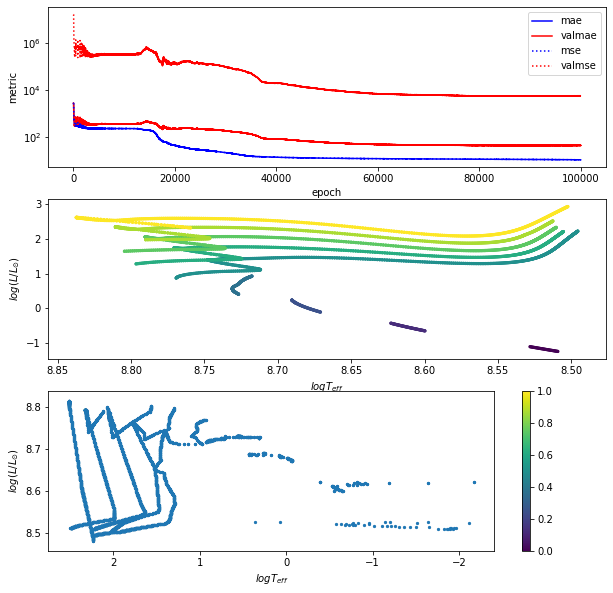

In [71]:
#running NN

''' 
#Functional form without progress bar
training = train_NN(input_data=np.vstack((data[[track_indeces],2],data[[track_indeces],3])),
         output_data=np.vstack(([data[[track_indeces],7],data[[track_indeces],8]])),
         new=True,
         epochs=100000,
         validation_fraction=0.1,
         nodes=100,
         Hidden_layers=6,
         regularization=False,
         learning_rate=0.001,
         beta_1=0.9995 ,
         beta_2=0.999,
         epsilon=1e-9)

''' 
#Non-functional form, with progress bar
input_data=np.vstack((data[[track_indeces],2],data[[track_indeces],3]))
output_data=np.vstack(([data[[track_indeces],7],data[[track_indeces],8]]))
new=True
epochs=100000
validation_fraction=0.1
nodes=100
Hidden_layers=6
regularization=False
learning_rate=0.001
beta_1=0.9995
beta_2=0.999
epsilon=1e-9


progress = epochs_progress(perc_step='ten')
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = NN_setup(new=new,input_data=input_data,output_data=output_data,nodes=nodes,Hidden_layers=Hidden_layers,regularization=regularization,learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2,epsilon=epsilon)
#print(np.shape(input_data))
#print(np.shape(output_data))
training = model.fit(input_data.T, output_data.T,
    epochs=epochs,
    batch_size=len(input_data[0]),
    validation_split=validation_fraction,
    verbose=0,
    callbacks=[epoch_progression()])
    
model.save('NN_small_grid.h5')
print('Training Finished at: '+str(datetime.now()))

plotHist(training=training,model=model,input_data=input_data.T)


#'''

5047/1 - 0s


C:\Users\Harry\Documents\Home\Anaconda\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in log


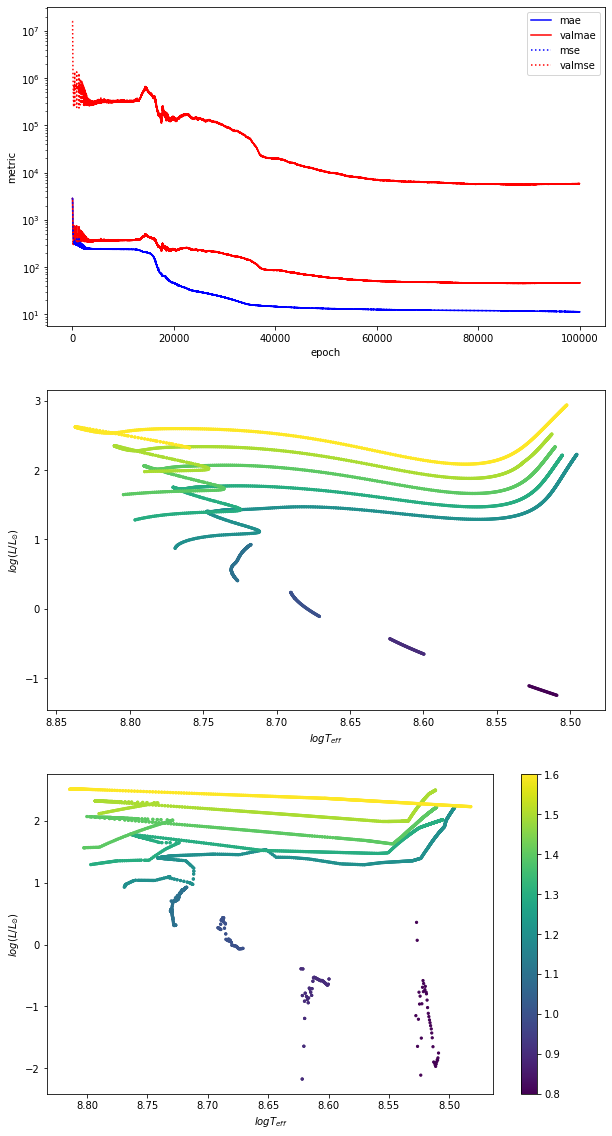

In [78]:
plotHist(training=training,model=model,input_data=input_data.T)


{'': 0, 'model_number': 1, 'star_mass': 2, 'star_age': 3, 'star_feh': 4, 'star_MLT': 5, 'star_fov': 6, 'effective_T': 7, 'luminosity': 8, 'radius': 9, 'log_g': 10, 'surface_h1': 11, 'surface_he4': 12, 'center_h1': 13, 'center_he4': 14, 'log_center_T': 15, 'log_center_Rho': 16, 'he_core_mass': 17, 'delta_nu': 18, 'delta_Pg': 19, 'nu_max': 20, 'nu_0_10': 21, 'nu_0_11': 22, 'nu_0_12': 23, 'nu_0_13': 24, 'nu_0_14': 25, 'nu_0_15': 26}
